# MATH516: Machine Learning and Artificial Intelligence for Healthcare  
## Coursework: EEG-Based Epilepsy Detection using Machine Learning  

<div style="font-size: 18px">

This coursework focuses on the practical application of machine learning and deep learning techniques to the analysis of biomedical EEG data for the detection of epilepsy. The project includes data preparation, exploratory data analysis, model development (classical machine learning and deep learning), model evaluation, feature importance analysis, and performance comparison.

</div>

---

### Student Details:

**Student Name**: Bala Murugan Balaji  
**Student Number**: *10941812*  
**Email**: bala.balaji@postgrad.plymouth.ac.uk              
**Course**: MSc Health Data Science and Statistics  
**University**: University of Plymouth   
**Year**: 2025  


# 1. Importing Required Libraries

In [315]:
# 1. Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History


# 2. Loading and Preprocessing the Dataset

In [335]:
# 2. Loading the dataset
df = pd.read_csv("Epileptic_featured _data.csv")  

# Dropping ID column and relabel class
df.drop('ID', axis=1, inplace=True)
df['stat'] = df['stat'].replace({2: 0})  # 1 = epileptic, 0 = non-epileptic

# Splitting features and target
X = df.drop('stat', axis=1)
y = df['stat']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print(df.columns)
print(df['stat'].unique())

print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns.tolist())

Index(['pow_d', 'fr_d', 'cd1_d', 'cd2_d', 'cd3_d', 'cd4_d', 'cd5_d', 'cd6_d',
       'pow_t', 'fr_t', 'cd1_t', 'cd2_t', 'cd3_t', 'cd4_t', 'cd5_t', 'cd6_t',
       'pow_a', 'fr_a', 'cd1_a', 'cd2_a', 'cd3_a', 'cd4_a', 'cd5_a', 'cd6_a',
       'pow_b', 'fr_b', 'cd1_b', 'cd2_b', 'cd3_b', 'cd4_b', 'cd5_b', 'cd6_b',
       'pow_g', 'fr_g', 'cd1_g', 'cd2_g', 'cd3_g', 'cd4_g', 'cd5_g', 'cd6_g',
       'stat'],
      dtype='object')
[1 0]
Dataset Shape: (198, 41)
Dataset Columns: ['pow_d', 'fr_d', 'cd1_d', 'cd2_d', 'cd3_d', 'cd4_d', 'cd5_d', 'cd6_d', 'pow_t', 'fr_t', 'cd1_t', 'cd2_t', 'cd3_t', 'cd4_t', 'cd5_t', 'cd6_t', 'pow_a', 'fr_a', 'cd1_a', 'cd2_a', 'cd3_a', 'cd4_a', 'cd5_a', 'cd6_a', 'pow_b', 'fr_b', 'cd1_b', 'cd2_b', 'cd3_b', 'cd4_b', 'cd5_b', 'cd6_b', 'pow_g', 'fr_g', 'cd1_g', 'cd2_g', 'cd3_g', 'cd4_g', 'cd5_g', 'cd6_g', 'stat']


# 3. Data Quality Checks

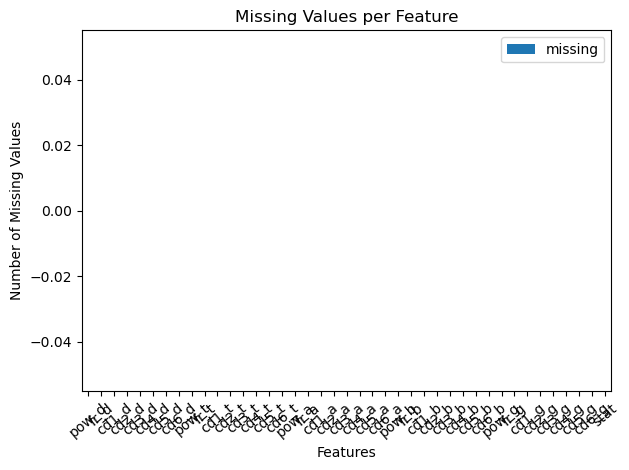

In [321]:
# Step 3.1: Checking for Missing Values
missingness = df.isna().sum().reset_index(name="missing").rename(columns={'index': 'feature'})
missingness.plot.bar(x='feature', y='missing', rot=40)
plt.title("Missing Values per Feature")
plt.xlabel("Features")
plt.ylabel("Number of Missing Values")
plt.tight_layout()
plt.savefig("fig_missing_values.jpeg")
plt.show()

# Saving missingness details
missingness.to_csv('eeg_missing_values.csv', index=False)

In [322]:
# Step 3.2: Outlier Detection using IQR

X = df.drop(columns=['stat'])
y = df['stat']

# Combining X and y
df_combined = pd.concat([pd.DataFrame(X, columns=df.drop(columns=['stat']).columns), y.reset_index(drop=True)], axis=1)

# Loop through each feature
for feature in df_combined.drop(columns=['stat']).columns:
    Q1 = df_combined[feature].quantile(0.25)
    Q3 = df_combined[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_combined = df_combined[(df_combined[feature] >= lower_bound) & (df_combined[feature] <= upper_bound)]

# Updated X and y after outlier removal
X = df_combined.drop(columns=['stat'])
y = df_combined['stat']

print(f"Dataset shape after outlier removal: {X.shape}")

Dataset shape after outlier removal: (12, 40)


# 4. Exploratory Data Analysis (EDA)

Class 0 (Non-Epileptic): 99
Class 1 (Epileptic): 99


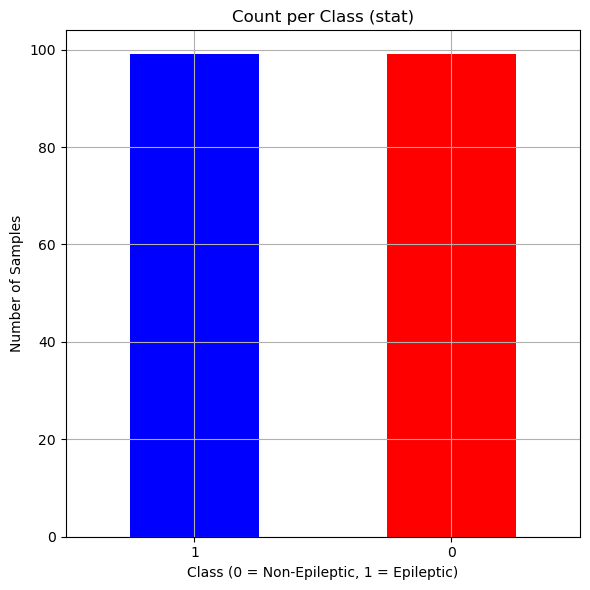

In [282]:
# Step 4.1: Plotting the Class Distribution
target_count = df['stat'].value_counts()
print('Class 0 (Non-Epileptic):', target_count[0])
print('Class 1 (Epileptic):', target_count[1])
plt.figure(figsize=(6,6))
target_count.plot(kind='bar', title='Count per Class (stat)', color=['blue', 'red'])
plt.xticks(rotation=0)
plt.xlabel('Class (0 = Non-Epileptic, 1 = Epileptic)')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.savefig('Class_distribution.jpeg')

plt.tight_layout()
plt.show()

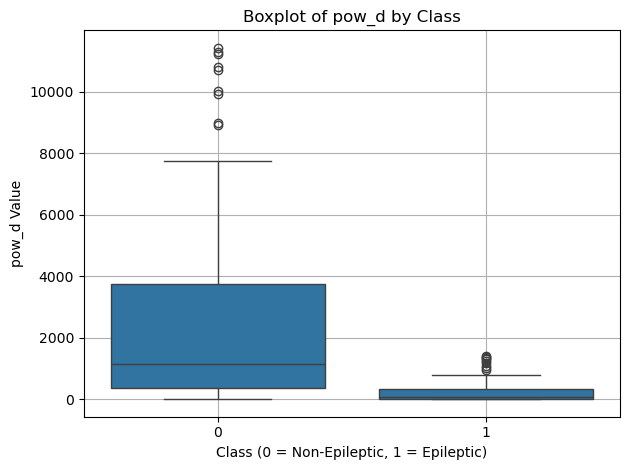

In [336]:
# Step 4.2: Boxplot for Single Feature
feature_to_plot = 'pow_d'
sns.boxplot(x=df['stat'], y=df[feature_to_plot])
plt.title(f'Boxplot of {feature_to_plot} by Class')
plt.xlabel('Class (0 = Non-Epileptic, 1 = Epileptic)')
plt.ylabel(f'{feature_to_plot} Value')
plt.grid(True)
plt.savefig('Boxplot_for_SF.jpeg')
plt.tight_layout()
plt.show()

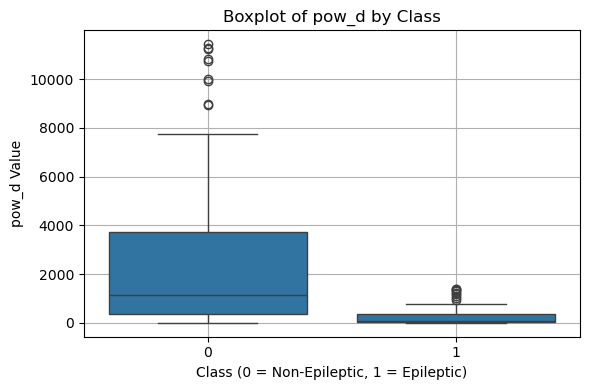

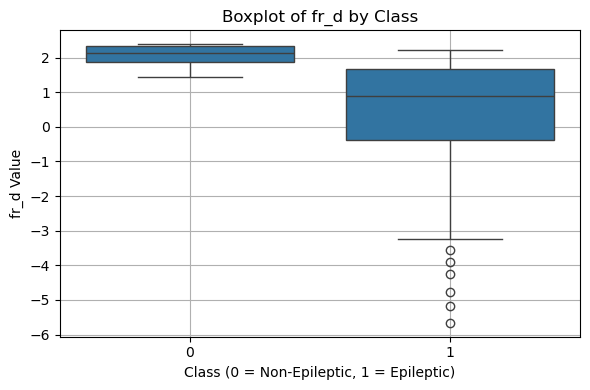

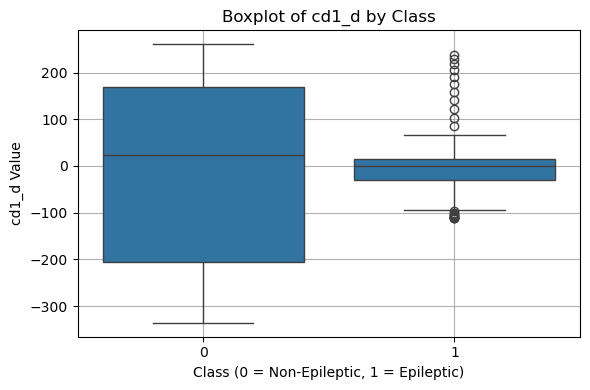

In [314]:
# Step 4.3: Boxplots for Selected Important Features (pow_d, fr_d, cd1_d
features_to_plot = ['pow_d', 'fr_d', 'cd1_d']  
for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df['stat'], y=df[feature])
    plt.title(f'Boxplot of {feature} by Class')
    plt.xlabel('Class (0 = Non-Epileptic, 1 = Epileptic)')
    plt.ylabel(f'{feature} Value')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'boxplot_{feature}_by_class.jpeg')
    plt.show()

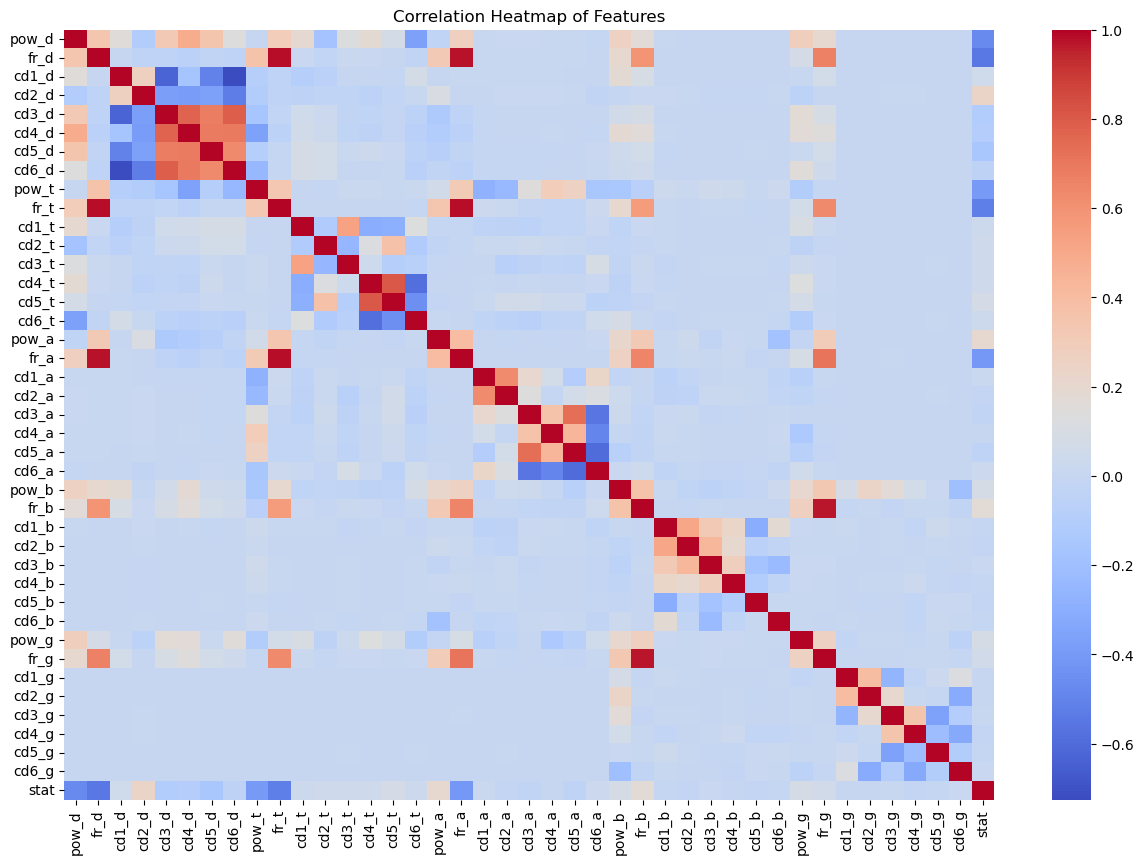

In [285]:
# Step 4.4: Data Exploration - Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.savefig('Correlation_heatmap.jpeg')
plt.show()

C:\Users\Bala Murugan Balaji\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


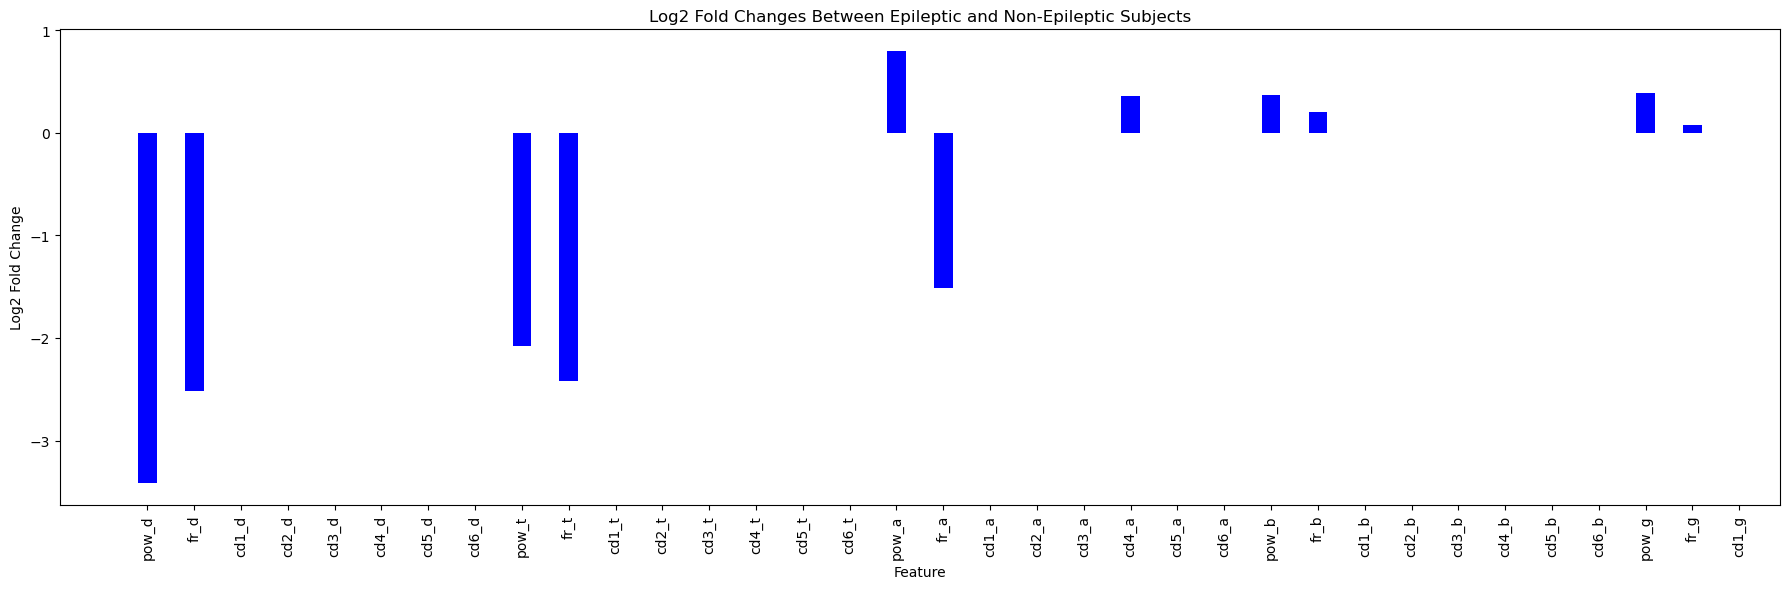

In [346]:
# Step 4.5: Fold Change Analysis
positive = df[df['stat'] == 1]
negative = df[df['stat'] == 0]
positive_means = positive.drop(columns=['stat']).mean()
negative_means = negative.drop(columns=['stat']).mean()
fold_changes = np.log2(positive_means / negative_means)
feat_means = pd.DataFrame({'feature': positive_means.index, 'fc': fold_changes.values})
plt.figure(figsize=(18,6))
plt.bar(feat_means['feature'], feat_means['fc'], color='blue', width=0.4)
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Log2 Fold Change')
plt.title('Log2 Fold Changes Between Epileptic and Non-Epileptic Subjects')
plt.tight_layout()
plt.savefig('fold_changes.jpeg')
plt.show()

# 5. Feature Selection

In [324]:
# Step 5.1: Feature and Target Separation
X = df.drop(columns=['stat'])
y = df['stat']

In [325]:
# Step 5.2: Data Normalization
X = df.drop(columns=['stat'])
y = df['stat']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [326]:
# Step 5.3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

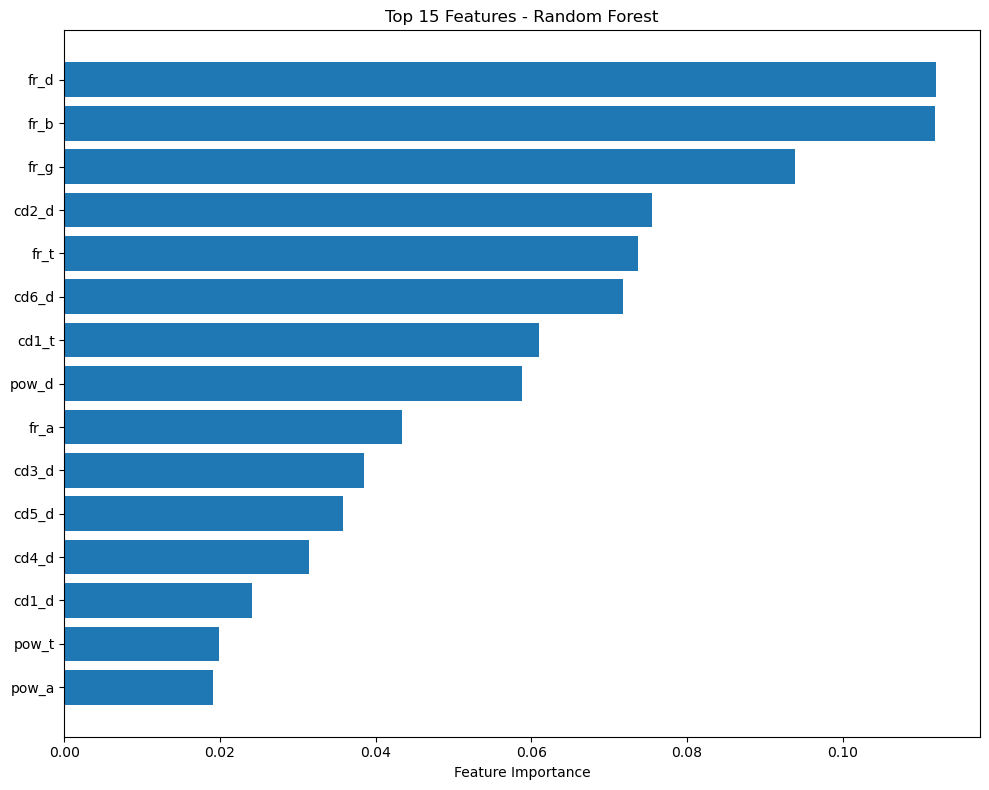

In [327]:
# Step 5.4: Feature Importance from Random Forest
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_names = df.drop(columns=['stat']).columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(15), importances[indices[:15]][::-1], align='center')
plt.yticks(range(15), feature_names[indices[:15]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features - Random Forest")
plt.tight_layout()
plt.savefig('random_forest_feature_importance.jpeg')
plt.show()

<Figure size 2200x800 with 0 Axes>

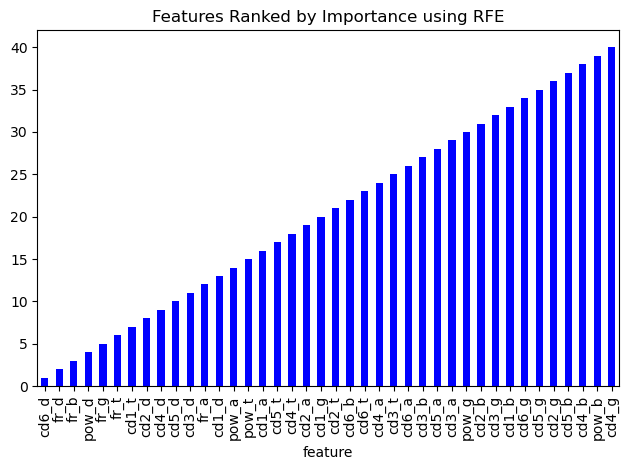

In [328]:
# Step 5.5: Recursive Feature Elimination (RFE)
rfe = RFE(RandomForestClassifier(), n_features_to_select=1)
rfe.fit(X_train, y_train)
rfe_ranking = rfe.ranking_
features = df.drop(columns=['stat']).columns
rfe_feature_ranking = pd.DataFrame({'feature': features, 'rank': rfe_ranking})
plt.figure(figsize=(22,8))
rfe_feature_ranking.sort_values(by='rank').plot.bar(x='feature', y='rank', rot=90, color='blue', legend=False)
plt.title('Features Ranked by Importance using RFE')
plt.tight_layout()
plt.savefig('rfe_feature_ranking.jpeg')
plt.show()

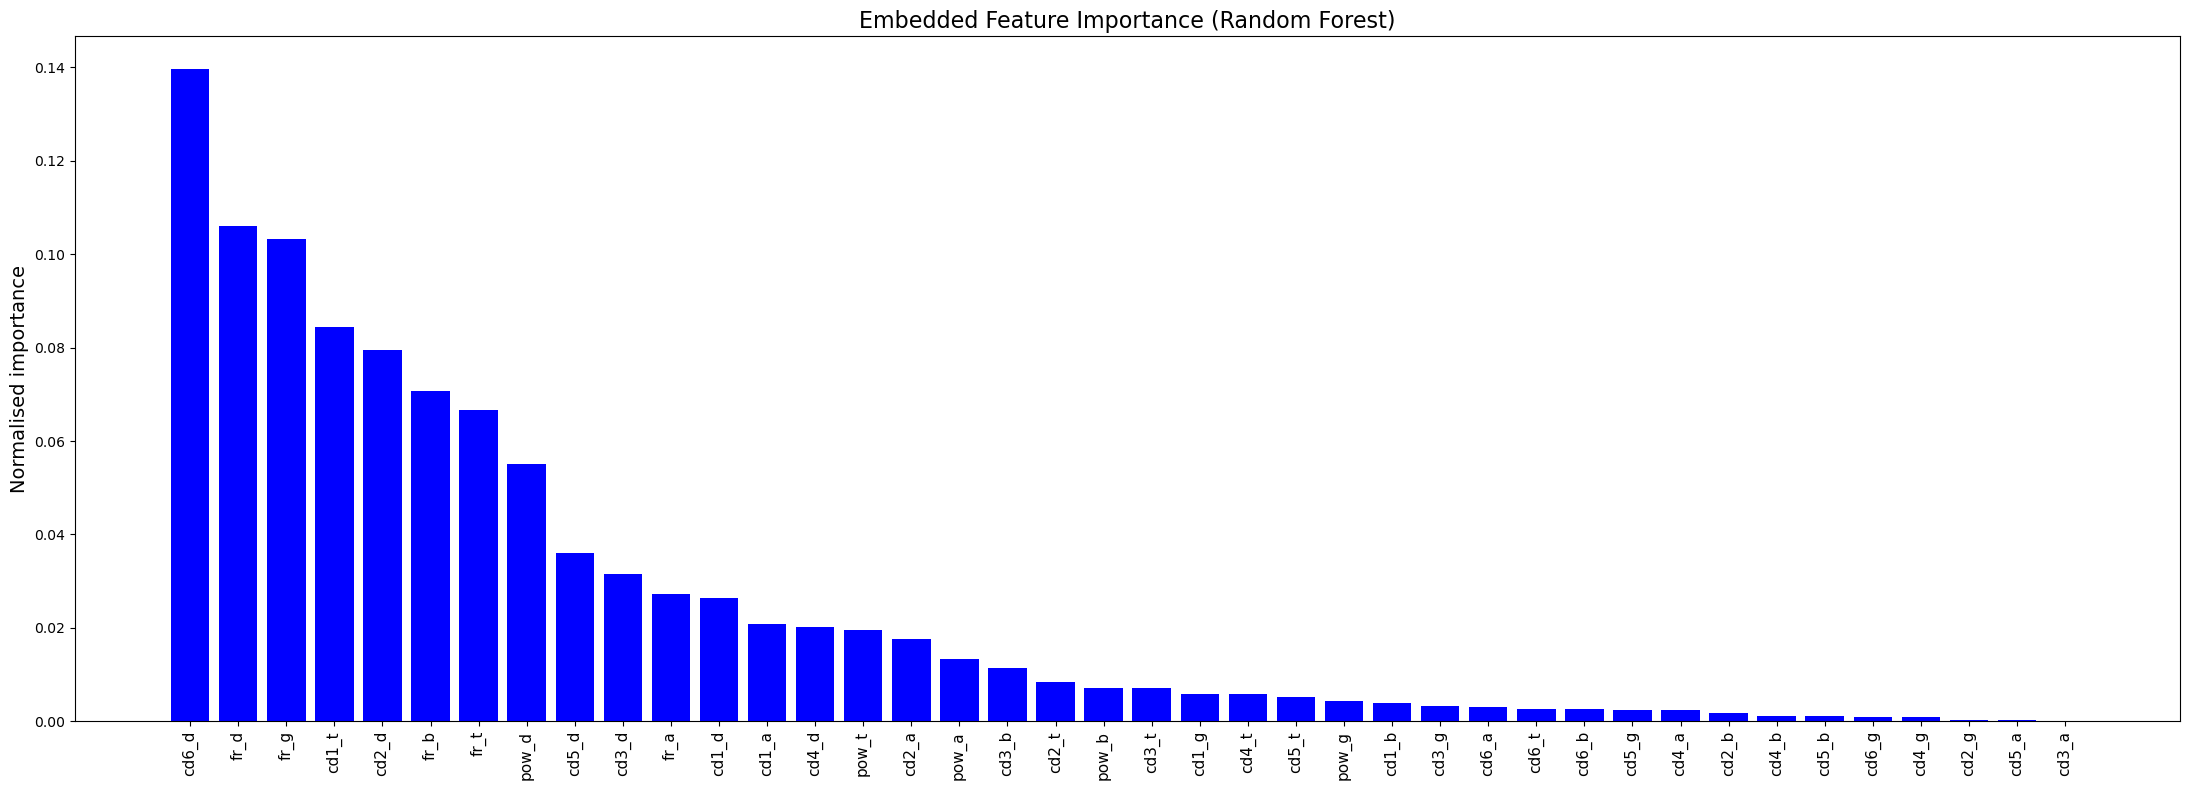

In [329]:
# Step 5.6: Embedded Feature Importance (Random Forest)
estimator_embed = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=2, min_samples_split=2, random_state=220)
estimator_embed.fit(X_train, y_train)
embedded_feature_ranking = pd.DataFrame({'feature': df.drop(columns=['stat']).columns, 'importance': estimator_embed.feature_importances_}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(22,8))
plt.bar(x=embedded_feature_ranking['feature'], height=embedded_feature_ranking['importance'], color='blue')
plt.xticks(rotation=90, fontsize=11)
plt.ylabel('Normalised importance', fontsize=14)
plt.title('Embedded Feature Importance (Random Forest)', fontsize=16)
plt.tight_layout()
plt.savefig('embedded_feature_importance.jpeg')
plt.show()

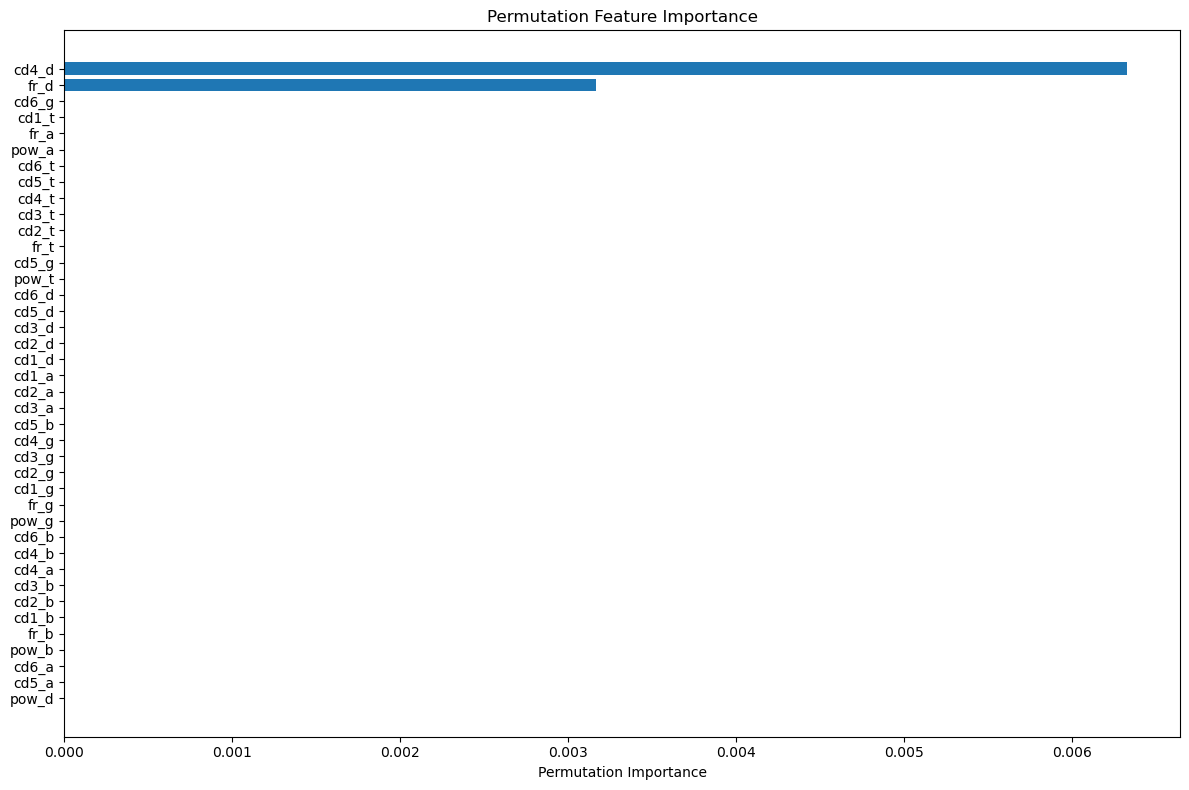

In [330]:
# Step 5.7: Permutation Feature Importance
result = permutation_importance(estimator_embed, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12,8))
plt.barh(range(len(perm_sorted_idx)), result.importances_mean[perm_sorted_idx], align='center')
plt.yticks(range(len(perm_sorted_idx)), df.drop(columns=['stat']).columns[perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.savefig('permutation_importance.jpeg')
plt.show()

<Figure size 2200x800 with 0 Axes>

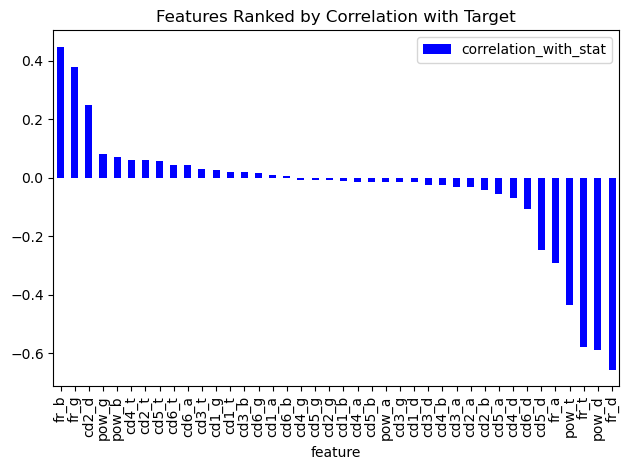

In [331]:
# Step 5.8: Correlation-Based Feature Ranking
correlation_mat = df.corr('spearman')
correlation_feature_rank = pd.DataFrame({'feature': correlation_mat.index, 'correlation_with_stat': correlation_mat['stat']})
correlation_feature_rank = correlation_feature_rank[correlation_feature_rank['feature'] != 'stat']
correlation_feature_rank = correlation_feature_rank.set_index('feature').sort_values(by='correlation_with_stat', ascending=False)
plt.figure(figsize=(22,8))
correlation_feature_rank.plot.bar(y='correlation_with_stat', color='blue')
plt.title('Features Ranked by Correlation with Target')
plt.tight_layout()
plt.savefig('correlation_feature_ranking.jpeg')
plt.show()

# 6. Machine Learning Model Development

In [333]:
# Step 6.1: Define and Train Classical Machine Learning Models

# Logistic Regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Support Vector Machine
model_svm = SVC(probability=True, random_state=42)
model_svm.fit(X_train, y_train)

# K-Nearest Neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [334]:
# Step 6.2: Store Models in a Dictionary for Easy Access
models = {
    'Logistic Regression': model_lr,
    'Random Forest': model_rf,
    'Support Vector Machine': model_svm,
    'K-Nearest Neighbors': model_knn
}

# Display model names
print("Trained Models:")
print(models)

Trained Models:
{'Logistic Regression': LogisticRegression(random_state=42), 'Random Forest': RandomForestClassifier(random_state=42), 'Support Vector Machine': SVC(probability=True, random_state=42), 'K-Nearest Neighbors': KNeighborsClassifier()}


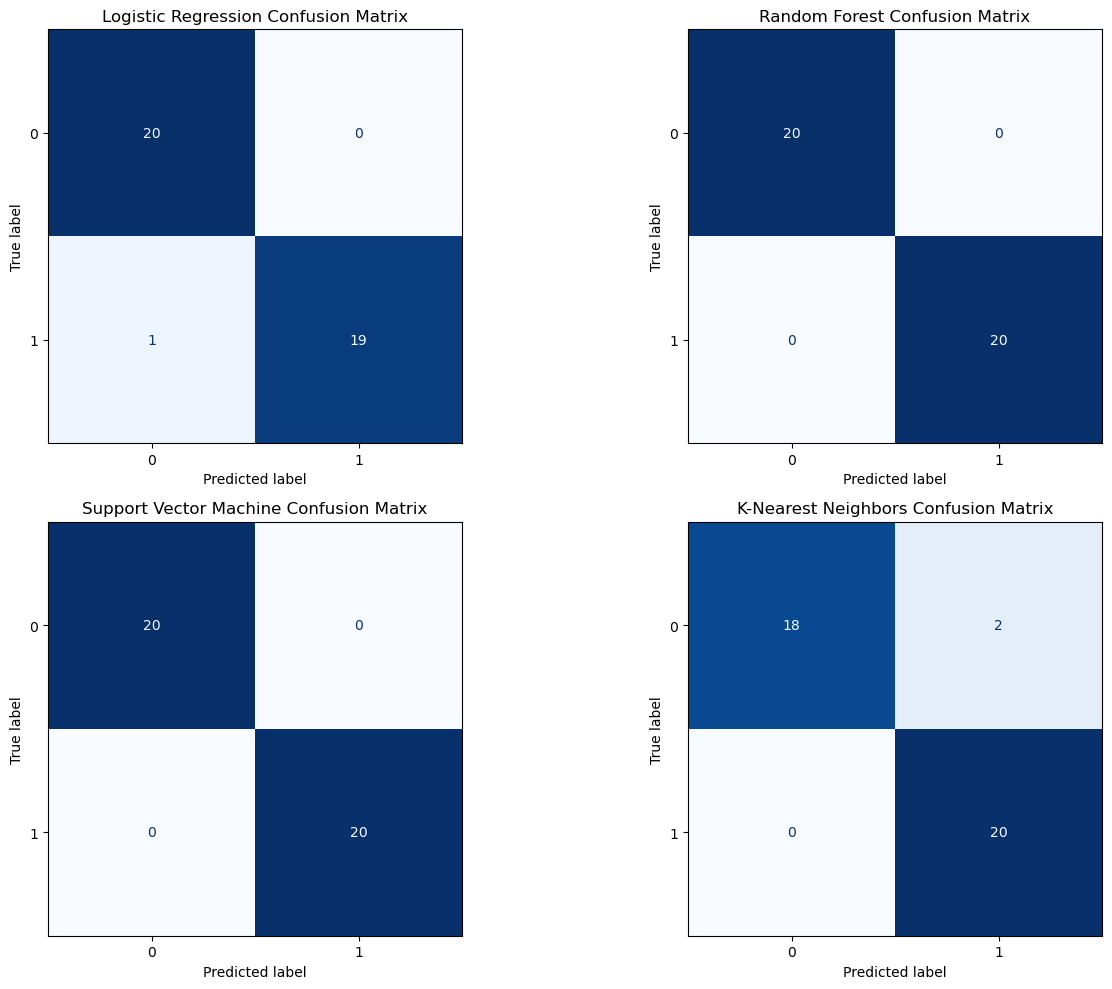

In [295]:
# Step 6.3: Confusion Matrices for ML models.
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test,
        ax=ax, cmap='Blues',
        colorbar=False
    )
    ax.title.set_text(f'{name} Confusion Matrix')

plt.tight_layout()
plt.savefig('Confusion Matrices for ML models.jpeg')
plt.show()

In [296]:
# Step 6.4: Classifier Optimization using GridSearchCV

from sklearn.model_selection import GridSearchCV

# Define model & parameter grid
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit on training data
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Best Parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [297]:
# Step 6.5: Model Performance Summary
results_df = pd.DataFrame(results)
print(results_df)

                    Model  Accuracy  Precision  Recall (Sensitivity)  \
0     Logistic Regression     0.975   1.000000                  0.95   
1           Random Forest     1.000   1.000000                  1.00   
2  Support Vector Machine     1.000   1.000000                  1.00   
3     K-Nearest Neighbors     0.950   0.909091                  1.00   

   Specificity  F1 Score     AUC  
0          1.0  0.974359  1.0000  
1          1.0  1.000000  1.0000  
2          1.0  1.000000  1.0000  
3          0.9  0.952381  0.9875  


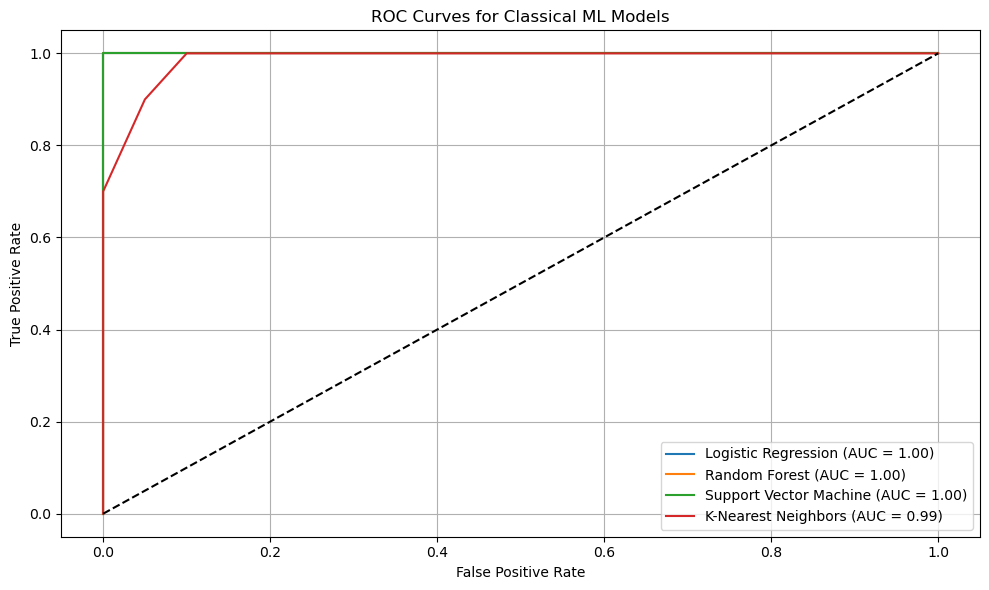

In [298]:
# Step 6.6: Plotting ROC Curves for ML Models
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classical ML Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ml_roc_curves.jpeg')
plt.show()

# 7. Deep Learning Model

In [305]:
# Step 7.1: Train Random Forest with Top 15 Features
top_features = feature_names[indices[:15]]
X_top = df[top_features]
X_top_scaled = scaler.fit_transform(X_top)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42, stratify=y)

rf_top = RandomForestClassifier(random_state=42)
rf_top.fit(X_train_top, y_train_top)
y_pred_top = rf_top.predict(X_test_top)
y_proba_top = rf_top.predict_proba(X_test_top)[:, 1]

print("Random Forest with Top 15 Features")
print("Accuracy:", accuracy_score(y_test_top, y_pred_top))
print("AUC:", roc_auc_score(y_test_top, y_proba_top))

Random Forest with Top 15 Features
Accuracy: 1.0
AUC: 1.0


In [306]:
# Step 7.2: Deep Learning Model with TensorFlow/Keras
model_dl = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_dl.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5132 - loss: 0.7631 - val_accuracy: 0.6875 - val_loss: 0.6068
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5490 - loss: 0.6729 - val_accuracy: 0.7188 - val_loss: 0.5765
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6006 - loss: 0.6268 - val_accuracy: 0.8125 - val_loss: 0.5459
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7232 - loss: 0.5500 - val_accuracy: 0.8438 - val_loss: 0.5195
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7716 - loss: 0.4960 - val_accuracy: 0.8438 - val_loss: 0.4915
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7673 - loss: 0.5125 - val_accuracy: 0.8750 - val_loss: 0.4650
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8148 - loss: 0.4657 - val_accuracy: 0.8750 - val_loss: 0.4412
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7897 - loss: 0.4188 - val_accuracy: 0.9062 - val_loss: 0.4176


In [307]:
# Step 7.3: Evaluation of Deep Learning Model
loss, accuracy = model_dl.evaluate(X_test, y_test)
print(f"Deep Learning Test Accuracy: {accuracy:.2f}")

y_pred_dl_proba = model_dl.predict(X_test).ravel()
y_pred_dl_class = (y_pred_dl_proba > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9729 - loss: 0.0701 
Deep Learning Test Accuracy: 0.98
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [308]:
# Step 7.4: Metrics for Deep Learning
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dl_class).ravel()
specificity = tn / (tn + fp)
print("Specificity (DL):", specificity)
print("Sensitivity (DL):", recall_score(y_test, y_pred_dl_class))
print("Precision (DL):", precision_score(y_test, y_pred_dl_class))
print("F1 Score (DL):", f1_score(y_test, y_pred_dl_class))
print("AUC (DL):", roc_auc_score(y_test, y_pred_dl_proba))

Specificity (DL): 1.0
Sensitivity (DL): 0.95
Precision (DL): 1.0
F1 Score (DL): 0.9743589743589743
AUC (DL): 1.0


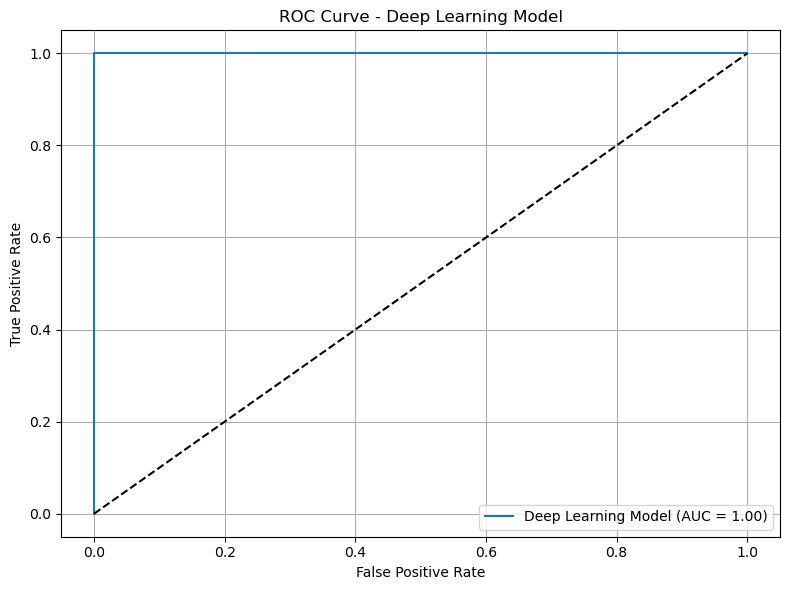

In [309]:
# Step 7.5: ROC Curve for Deep Learning
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_dl_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr_dl, tpr_dl, label=f"Deep Learning Model (AUC = {roc_auc_score(y_test, y_pred_dl_proba):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Deep Learning Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dl_roc_curve.jpeg')
plt.show()

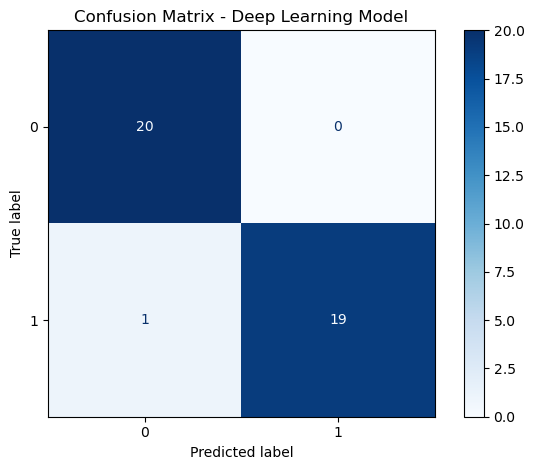

In [310]:
# Step 7.6: Confusion Matrix for Deep Learning
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dl_class, cmap='Blues')
plt.title('Confusion Matrix - Deep Learning Model')
plt.tight_layout()
plt.savefig('Confusion Matrix for DNN.jpeg')
plt.show()

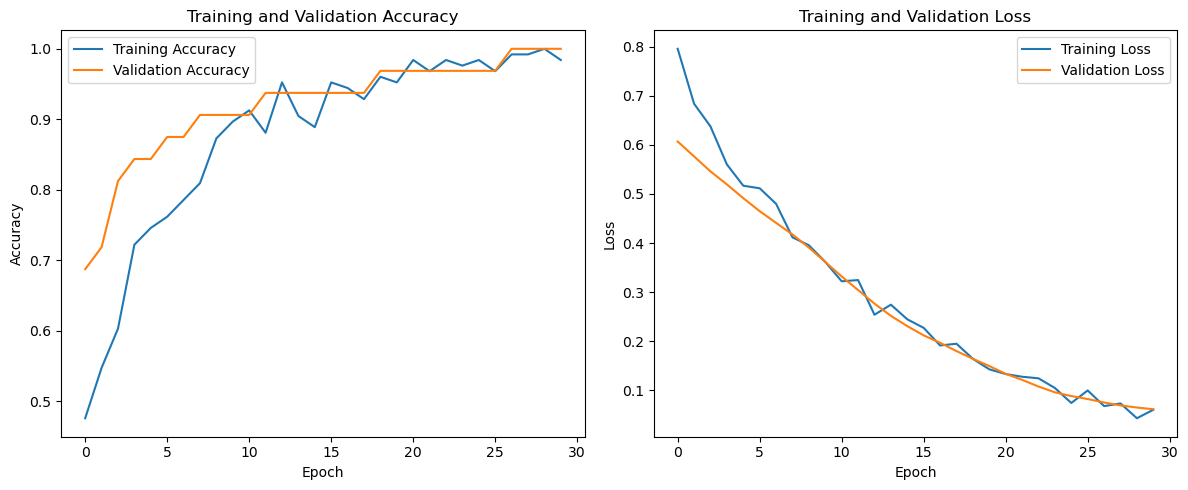

In [311]:
#7.7: Plotting Training Accuracy and Loss (DNN)
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Training Loss & Accuracy Curves.jpeg')
plt.tight_layout()
plt.show()

### Deep Learning Model Summary

The Deep Learning model achieved high classification performance, with an accuracy and AUC comparable to the classical machine learning models. This demonstrates that both classical ML and deep learning approaches are effective for EEG-based epilepsy detection in this dataset.
